In [1]:
import numpy as np
from qiskit_mps_initializer.datatypes import QuantumState

# Example: use 3 qubits => vectors of length 8
psi = np.array([1, 2, 3, 4, 5, 6, 7, 8], dtype=complex)
phi = np.array([8, 7, 6, 5, 4, 3, 2, 1], dtype=complex)

# Normalize
psi = psi / np.linalg.norm(psi)
phi = phi / np.linalg.norm(phi)


In [2]:
delta = np.pi / 4             # phase shift parameter
num_qubits = 3                # number of qubits (length of vector = 2^n)
number_of_cycles = 3          # how many cycles to run


Current error: 1.3638079012812616
Current number of layers: 0
Current error: 0.7653668647301797
Current number of layers: 0


/workspaces/QCproject/.venv/lib/python3.13/site-packages/cotengra/hyperoptimizers/hyper.py:55: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization. It is recommended to install one of these libraries for higher quality contraction paths.
  warnings.warn(


Statevector([0.070014  +0.j, 0.14002801+0.j, 0.21004201+0.j,
             0.28005602+0.j, 0.35007002+0.j, 0.42008403+0.j,
             0.49009803+0.j, 0.56011203+0.j],
            dims=(2, 2, 2))

Statevector comparison (ψ vs ϕ):
|000>: ψ=(0.07001400420140058+0j), ϕ=(0.7071067811865476+0j), Δphase=0.000 rad
|001>: ψ=(0.14002800840280102+0j), ϕ=(4.329780281177467e-17+0j), Δphase=0.000 rad
|010>: ψ=(0.21004201260420152+0j), ϕ=0j, Δphase=0.000 rad
|011>: ψ=(0.28005601680560194+0j), ϕ=0j, Δphase=0.000 rad
|100>: ψ=(0.35007002100700263+0j), ϕ=0j, Δphase=0.000 rad
|101>: ψ=(0.42008402520840316+0j), ϕ=0j, Δphase=0.000 rad
|110>: ψ=(0.4900980294098035+0j), ϕ=(-3.0616169978683836e-17-3.061616997868383e-17j), Δphase=-2.356 rad
|111>: ψ=(0.5601120336112039+0j), ϕ=(0.7071067811865476+0j), Δphase=0.000 rad


/tmp/ipykernel_977/93348672.py:54: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  for i, (amp_psi, amp_phi) in enumerate(zip(psi_statevector, phi_statevector)):
/tmp/ipykernel_977/93348672.py:60: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  psi_probs = {f"{i:03b}": np.abs(amp)**2 for i, amp in enumerate(psi_statevector)}
/tmp/ipykernel_977/93348672.py:62: Depr

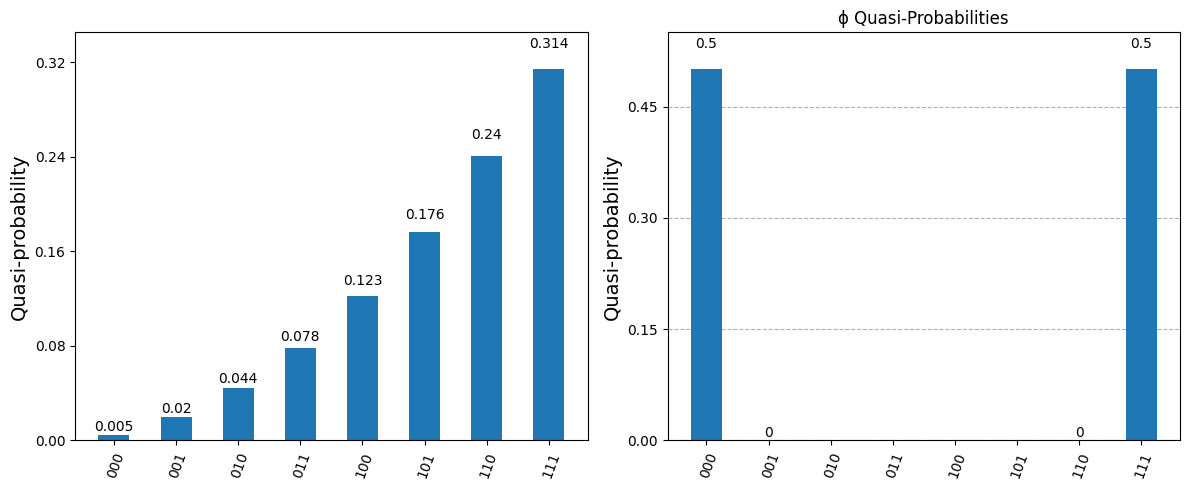

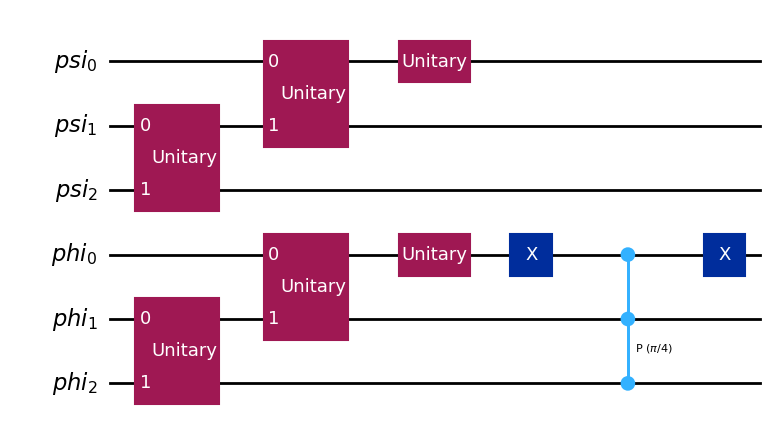

In [3]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit_mps_initializer.datatypes import QuantumState
from qiskit.visualization import plot_histogram
from matplotlib import pyplot as plt
from qiskit_aer import AerSimulator

# Two arbitrary vectors (you can choose your own)
psi = [1, 2, 3, 4, 5, 6, 7, 8]
phi = [1, 0, 0, 0, 0, 0, 0, 1]

# Create QuantumState objects and MPS-style initializer circuits
psi_state = QuantumState.from_dense_data(data=psi, normalize=True)
phi_state = QuantumState.from_dense_data(data=phi, normalize=True)

psi_circuit = psi_state.generate_mps_initializer_circuit(number_of_layers=2)
phi_circuit = phi_state.generate_mps_initializer_circuit(number_of_layers=2)

# Create two quantum registers
n_psi = psi_circuit.num_qubits
n_phi = phi_circuit.num_qubits

psi_reg = QuantumRegister(n_psi, name="psi")
phi_reg = QuantumRegister(n_phi, name="phi")
circuit = QuantumCircuit(psi_reg, phi_reg)


phi_circuit.x(0)
phi_circuit.mcp(np.pi/4, [0, 1], 2)
phi_circuit.x(0)


# Append the circuits to the respective registers
circuit.compose(psi_circuit, qubits=psi_reg, inplace=True)
circuit.compose(phi_circuit, qubits=phi_reg, inplace=True)

simulator = AerSimulator(method='automatic')

#psi
psi_sv = psi_circuit.copy()
psi_sv.save_statevector()
psi_result = simulator.run(transpile(psi_sv, simulator)).result()
psi_statevector = psi_result.get_statevector()

print(psi_statevector)

#for phi
phi_sv = phi_circuit.copy()
phi_sv.save_statevector()
phi_result = simulator.run(transpile(phi_sv, simulator)).result()
phi_statevector = phi_result.get_statevector()

# Compare amplitudes and phase difference
print("\nStatevector comparison (ψ vs ϕ):")
for i, (amp_psi, amp_phi) in enumerate(zip(psi_statevector, phi_statevector)):
    basis = f"|{format(i, '03b')}>"
    delta_phase = np.angle(amp_phi) - np.angle(amp_psi)
    print(f"{basis}: ψ={amp_psi}, ϕ={amp_phi}, Δphase={delta_phase:.3f} rad")


psi_probs = {f"{i:03b}": np.abs(amp)**2 for i, amp in enumerate(psi_statevector)}

phi_probs = {f"{i:03b}": np.abs(amp)**2 for i, amp in enumerate(phi_statevector)}

# Plot quasi-probabilities as histogram
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
plot_histogram(psi_probs, ax=axs[0], title="ψ Quasi-Probabilities")
plot_histogram(phi_probs, ax=axs[1], title="ϕ Quasi-Probabilities")
plt.tight_layout()
plt.show()

# Optional: Add measurements if needed
# circuit.measure_all()

# Draw the combined circuit
circuit.draw("mpl")


Current error: 1.3638079012812616
Current number of layers: 0
Current error: 1.3638079012812616
Current number of layers: 0
Full statevector:
 Statevector([ 3.46620971e-03+3.46620971e-03j,
              9.80392157e-03-6.00317058e-19j,
              1.47058824e-02-9.00475588e-19j,
              1.38648388e-02+1.38648388e-02j,
              2.45098039e-02-1.50079265e-18j,
              2.94117647e-02-1.80095118e-18j,
              2.42634680e-02+2.42634680e-02j,
              3.92156863e-02-2.40126823e-18j,
              9.80392157e-03+3.00158529e-19j,
              1.38648388e-02+1.38648388e-02j,
              2.94117647e-02+9.00475588e-19j,
              2.77296777e-02+2.77296777e-02j,
              4.90196078e-02+1.50079265e-18j,
              5.88235294e-02+1.80095118e-18j,
              6.86274510e-02+2.10110970e-18j,
              5.54593554e-02+5.54593554e-02j,
              1.47058824e-02-3.00158529e-19j,
              2.94117647e-02-6.00317058e-19j,
              3.11958874e-02+

/workspaces/QCproject/.venv/lib/python3.13/site-packages/cotengra/hyperoptimizers/hyper.py:55: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization. It is recommended to install one of these libraries for higher quality contraction paths.
  warnings.warn(


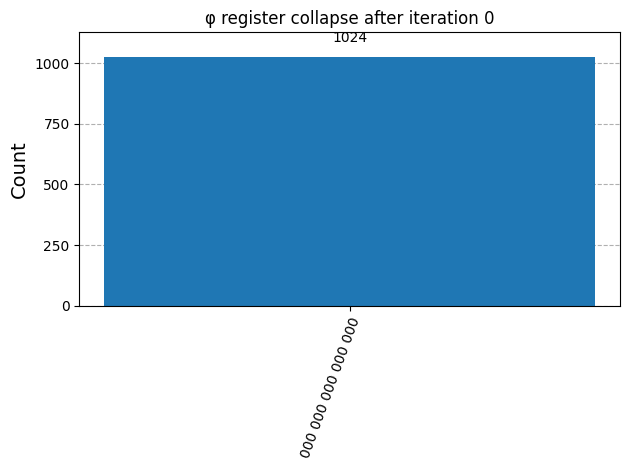

Iteration 1 ancilla outcomes: {'000 000 000 000 000': 1024}


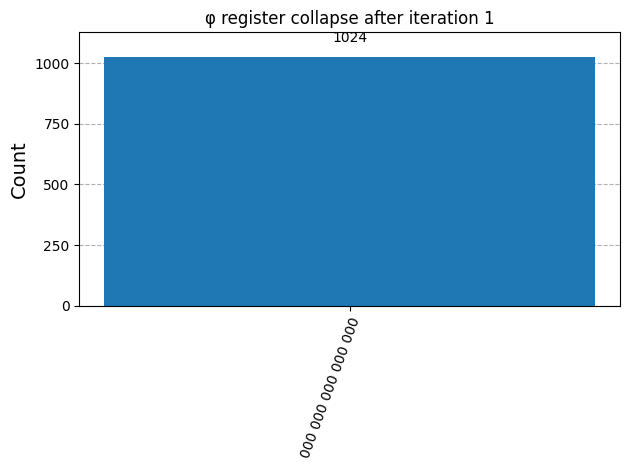

Iteration 2 ancilla outcomes: {'000 000 000 000 000': 1024}


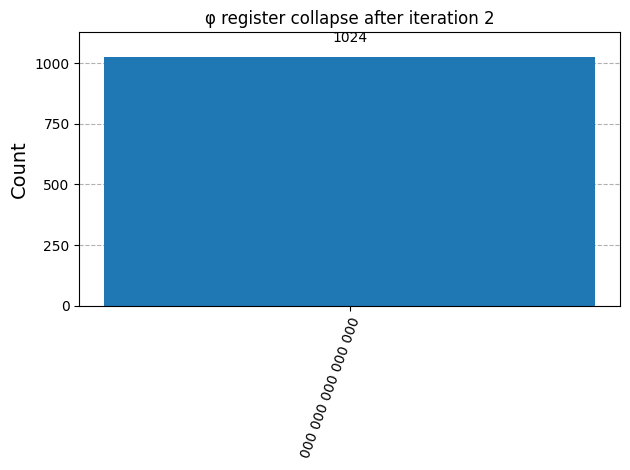

Iteration 3 ancilla outcomes: {'000 000 000 000 000': 1024}


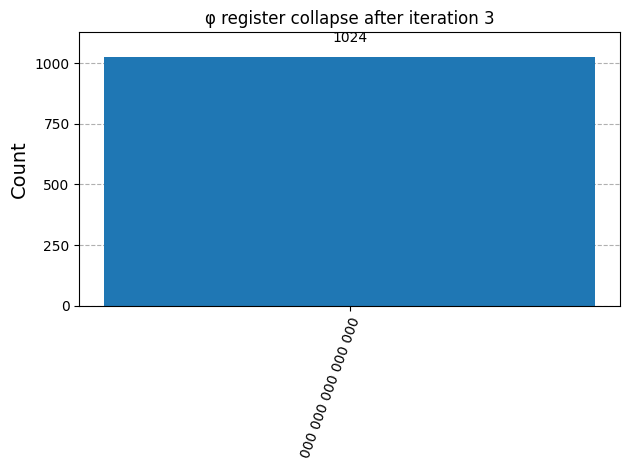

Iteration 4 ancilla outcomes: {'000 000 000 000 000': 1024}


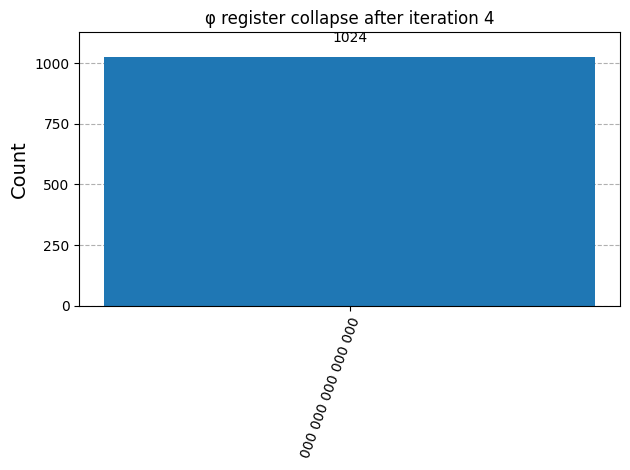

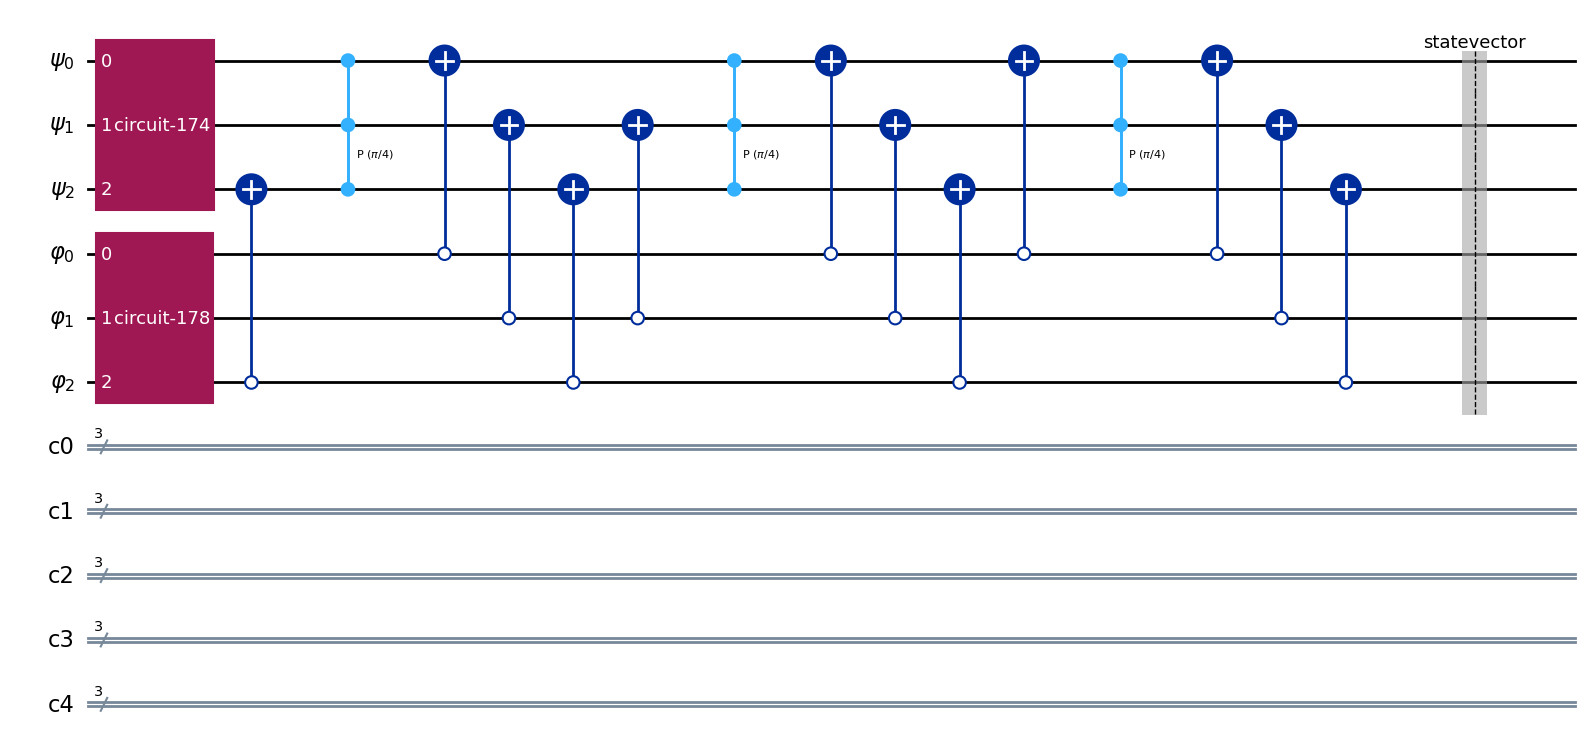

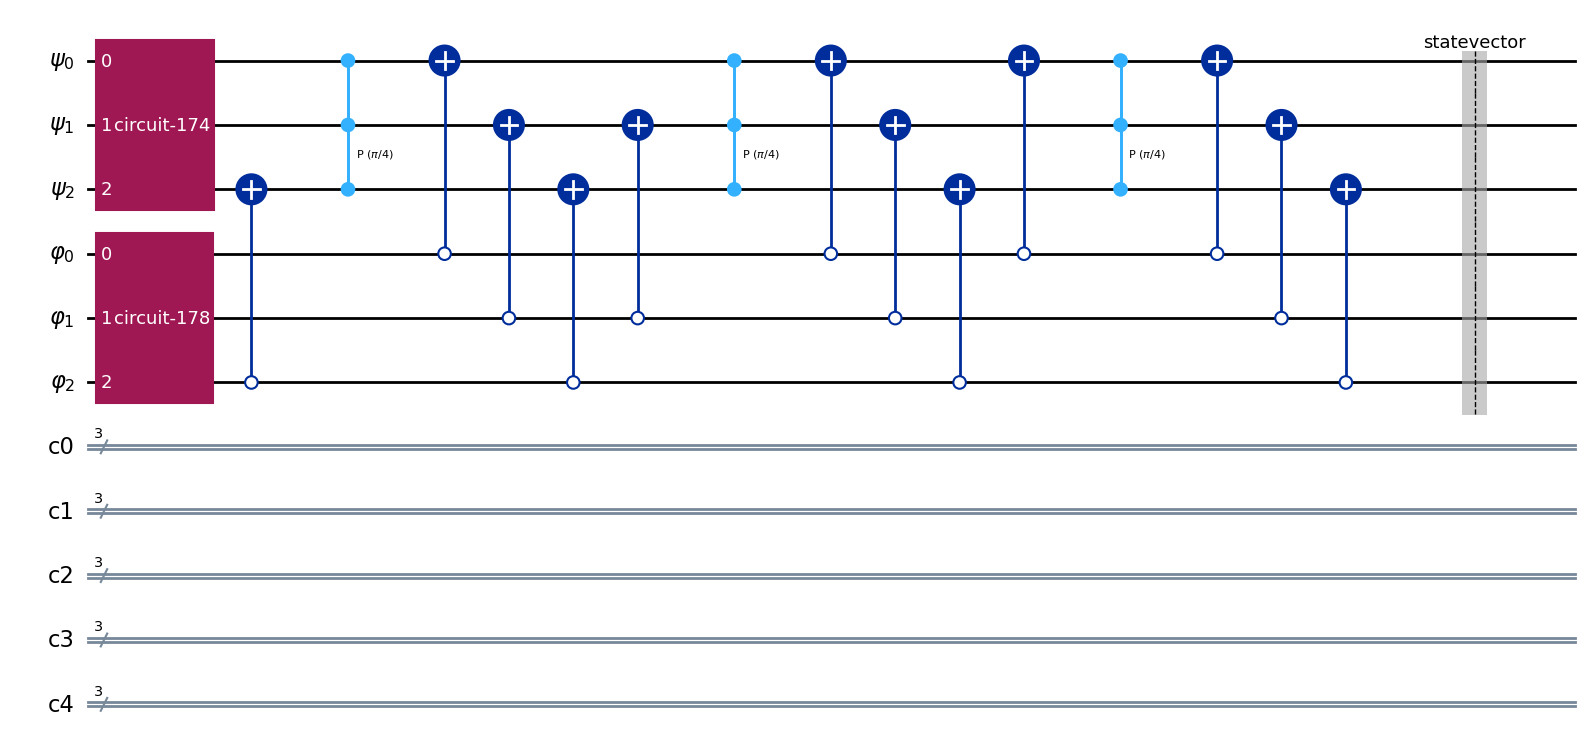

In [1]:
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit_mps_initializer.datatypes import QuantumState
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt
from qiskit.quantum_info import partial_trace, DensityMatrix, state_fidelity
%matplotlib inline

psi = [1, 2, 3, 4, 5, 6, 7, 8]
phi = [1, 2, 3, 4, 5, 6, 7, 8]
n = 3  
m = 5
delta = np.pi / 4  # Phase to be added
number_of_layers = 2

psi_state = QuantumState.from_dense_data(data=psi, normalize=True)
phi_state = QuantumState.from_dense_data(data=phi, normalize=True)

U_psi = psi_state.generate_mps_initializer_circuit(number_of_layers=number_of_layers)
U_phi = phi_state.generate_mps_initializer_circuit(number_of_layers=number_of_layers)

U_phi_dagger = U_phi.inverse()

psi_reg = QuantumRegister(n, name="ψ")
phi_reg = QuantumRegister(n, name="φ")
cregs = [ClassicalRegister(n, name=f"c{k}") for k in range(m)]
qc = QuantumCircuit(psi_reg, phi_reg, *cregs)

#for psi
qc.append(U_psi, psi_reg)

#for phi
qc.append(U_phi, phi_reg)


for i in range(n):
    qc.cx(phi_reg[n-1-i], psi_reg[n-1-i], ctrl_state=0)

# add phase
    qc.mcp(delta, psi_reg[0:-1], psi_reg[-1])

# reset the circuit
    for i in range(n):
        qc.cx(phi_reg[i], psi_reg[i], ctrl_state=0)

    
        

qc.save_statevector()

#simulate
sim = AerSimulator()
result = sim.run(transpile(qc, sim)).result()

# Full statevector
full = result.get_statevector(qc)

rho_psi = partial_trace(full, list(range(n, 2*n)))

print("Full statevector:\n", full)

for k in range(m):
    counts = result.get_counts(qc)  # pass the specific register
    print(f"Iteration {k} ancilla outcomes:", counts)
    
    # Plot histogram
    plot_histogram(counts, title=f"φ register collapse after iteration {k}")
    plt.show()

# Measurement Z





qc.draw('mpl')
